<center>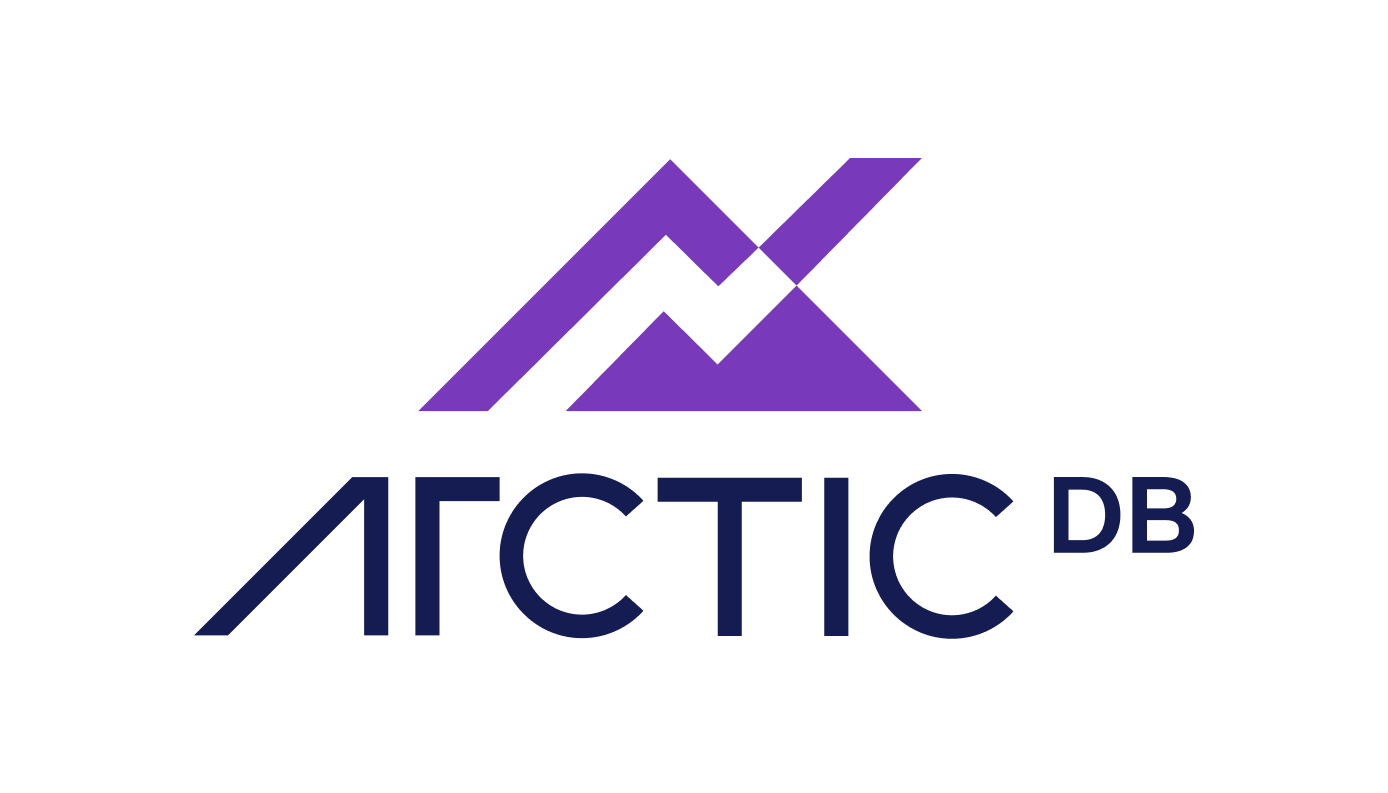
</center>

# ArcticDB Read as Arrow demo

This notebook demonstrates ArcticDB's Arrow-based output formats: **PyArrow** and **Polars**. These formats provide performance improvements for string-heavy workloads, and allow better integrations with modern Arrow-based table processing libraries like `polars` and `duckdb`.

**Key benefits:**
- **Better performance**: Particularly for string columns (no GIL required)
- **Zero-copy integration with Arrow**: Zero-copy pass dataframes from `arctidb` to third party libraries like `duckdb`

**Notebook structure:**
1. Setup and basic usage
2. Polars output format
3. PyArrow output format and record batch structure
4. Configurable string formats
5. Pandas interoperability and column naming
6. Performance benchmarks

# Setup

In [1]:
import numpy as np
import pandas as pd
import polars as pl
import pyarrow as pa
from arcticdb import Arctic, LibraryOptions, OutputFormat, ArrowOutputStringFormat, where

In [2]:
ac = Arctic("lmdb://tmp/arrow_reads_demo")

In [3]:
ac.delete_library("arrow")
lib = ac.create_library("arrow")

In [4]:
sym = "test"

# Polars Output Format

All ArcticDB operations returning dataframes (e.g. `read`, `head`, `tail`, `read_batch`, `read_batch_and_join`) accept an `output_format` which controls in which format will the data be returned. The default output format is still `OutputFormat.PANDAS` which return `pd.DataFrame`s as before.

The Apache Arrow memory layout based output formats are `POLARS` which returns `polars.DataFrame` objects and `PYARROW` which returns `pyarrow.Table` objects.

Let's see several examples of using `POLARS` output format

In [5]:
## Basic Usage

# Write some data with Pandas (writing Polars/Arrow directly is not yet supported)
df = pd.DataFrame({
    "col_int": np.arange(10, dtype=np.int64),
    "col_float": np.arange(10, 20, dtype=np.float64),
    "col_str": [f"value_{i}" for i in range(10)]
})
lib.write("demo", df)
df

,col_int,col_float,col_str
0,0,10.0,value_0
1,1,11.0,value_1
2,2,12.0,value_2
3,3,13.0,value_3
4,4,14.0,value_4
5,5,15.0,value_5
6,6,16.0,value_6
7,7,17.0,value_7
8,8,18.0,value_8
9,9,19.0,value_9


Read back as a Polars DataFrame:

In [6]:
polars_df = lib.read("demo", output_format=OutputFormat.POLARS).data
print(f"Type: {type(polars_df)}")
print(f"Dtypes: {polars_df.dtypes}")
polars_df

Type: <class 'polars.dataframe.frame.DataFrame'>
Dtypes: [Int64, Float64, String]


col_int,col_float,col_str
i64,f64,str
0,10.0,"""value_0"""
1,11.0,"""value_1"""
2,12.0,"""value_2"""
3,13.0,"""value_3"""
4,14.0,"""value_4"""
5,15.0,"""value_5"""
6,16.0,"""value_6"""
7,17.0,"""value_7"""
8,18.0,"""value_8"""


### Index Handling

Note that default `RangeIndex` is dropped (Polars has no concept of row indexes):

## Configuration Levels

Output format can be set at three levels (Arctic instance, Library, or per-read):

In [7]:
# Per-read (most granular)
polars_df = lib.read("demo", output_format=OutputFormat.POLARS).data

# Case-insensitive strings also work
polars_df = lib.head("demo", output_format="polars").data
polars_df

col_int,col_float,col_str
i64,f64,str
0,10.0,"""value_0"""
1,11.0,"""value_1"""
2,12.0,"""value_2"""
3,13.0,"""value_3"""
4,14.0,"""value_4"""


Set at library level:

In [8]:
lib_polars = ac.get_library("arrow", output_format=OutputFormat.POLARS)
# Now all reads default to Polars
lib_polars.head("demo").data

col_int,col_float,col_str
i64,f64,str
0,10.0,"""value_0"""
1,11.0,"""value_1"""
2,12.0,"""value_2"""
3,13.0,"""value_3"""
4,14.0,"""value_4"""


### Or on the entire `Arctic` instance, so all libraries fetched from this instance use Arrow as the default return type

In [9]:
polars_ac = Arctic("lmdb://tmp/arrow_reads_demo_2", output_format=OutputFormat.POLARS)

# Now all libraries will have a default polars output format
polars_ac.delete_library("arrow")
lib = polars_ac.create_library("arrow")
lib.write("demo", df)
lib.head("demo").data

col_int,col_float,col_str
i64,f64,str
0,10.0,"""value_0"""
1,11.0,"""value_1"""
2,12.0,"""value_2"""
3,13.0,"""value_3"""
4,14.0,"""value_4"""


You can always override back to Pandas for individual reads:

In [10]:
pandas_df = lib.read("demo", output_format=OutputFormat.PANDAS).data
type(pandas_df)

pandas.core.frame.DataFrame

## Working with timeseries indices

Timeseries indices appear as the first column:

In [11]:
df = pd.DataFrame({
    "col_int": np.arange(10, dtype=np.int64),
    "col_float": np.arange(10, 20, dtype=np.float64)
}, index=pd.date_range("2025-01-01", periods=10))
df.index.name = "timestamp"
lib.write("timeseries", df)
df

,col_int,col_float
timestamp,,
2025-01-01,0,10.0
2025-01-02,1,11.0
2025-01-03,2,12.0
2025-01-04,3,13.0
2025-01-05,4,14.0
2025-01-06,5,15.0
2025-01-07,6,16.0
2025-01-08,7,17.0
2025-01-09,8,18.0


In [12]:
polars_df = lib.read("timeseries").data
print(f"Columns: {polars_df.columns}")
print(f"Dtypes: {polars_df.dtypes}")
polars_df

Columns: ['timestamp', 'col_int', 'col_float']
Dtypes: [Datetime(time_unit='ns', time_zone=None), Int64, Float64]


timestamp,col_int,col_float
datetime[ns],i64,f64
2025-01-01 00:00:00,0,10.0
2025-01-02 00:00:00,1,11.0
2025-01-03 00:00:00,2,12.0
2025-01-04 00:00:00,3,13.0
2025-01-05 00:00:00,4,14.0
2025-01-06 00:00:00,5,15.0
2025-01-07 00:00:00,6,16.0
2025-01-08 00:00:00,7,17.0
2025-01-09 00:00:00,8,18.0


Timezones are preserved:

In [13]:
df_tz = pd.DataFrame({
    "value": np.arange(5)
}, index=pd.date_range("2025-01-01", periods=5, tz="America/New_York"))
df_tz.index.name = "timestamp"
lib.write("tz_data", df_tz)
df_tz

,value
timestamp,
2025-01-01 00:00:00-05:00,0
2025-01-02 00:00:00-05:00,1
2025-01-03 00:00:00-05:00,2
2025-01-04 00:00:00-05:00,3
2025-01-05 00:00:00-05:00,4


In [14]:
polars_df = lib.read("tz_data").data
print(f"Timezone preserved: {polars_df['timestamp'].dtype}")
polars_df

Timezone preserved: Datetime(time_unit='ns', time_zone='America/New_York')


timestamp,value
"datetime[ns, America/New_York]",i64
2025-01-01 00:00:00 EST,0
2025-01-02 00:00:00 EST,1
2025-01-03 00:00:00 EST,2
2025-01-04 00:00:00 EST,3
2025-01-05 00:00:00 EST,4


## Filtering and Column Selection

Standard ArcticDB operations work with Arrow output formats:

*Note that index column is fetched even if not specified in the `columns` list.*

In [15]:
polars_df = lib.read(
    "timeseries",
    date_range=(pd.Timestamp("2025-01-03"), pd.Timestamp("2025-01-06")),
    columns=["col_int"]
).data
polars_df

timestamp,col_int
datetime[ns],i64
2025-01-03 00:00:00,2
2025-01-04 00:00:00,3
2025-01-05 00:00:00,4
2025-01-06 00:00:00,5


# PyArrow Output Format

The PyArrow output format returns `pyarrow.Table` objects. While we recommend Polars for most arrow use cases, PyArrow is useful when you want to integrate with other Arrow-based tools which expect a `pyarrow.Table`.

## Basic PyArrow Usage

In [16]:
arrow_table = lib.read("demo", output_format=OutputFormat.PYARROW).data
print(f"Type: {type(arrow_table)}")
print(f"Schema: {arrow_table.schema}")
arrow_table

Type: <class 'pyarrow.lib.Table'>
Schema: col_int: int64
col_float: double
col_str: large_string
-- schema metadata --
pandas: '{"index_columns": [{"name": null, "start": 0, "step": 1, "stop":' + 500


pyarrow.Table
col_int: int64
col_float: double
col_str: large_string
----
col_int: [[0,1,2,3,4,5,6,7,8,9]]
col_float: [[10,11,12,13,14,15,16,17,18,19]]
col_str: [["value_0","value_1","value_2","value_3","value_4","value_5","value_6","value_7","value_8","value_9"]]

## Zero-Copy Conversion Between Arrow based libraries

Converting between PyArrow and Polars is zero-copy since they share the same memory layout:

In [17]:
# PyArrow to Polars (zero-copy)
polars_from_arrow = pl.from_arrow(arrow_table)
print(f"Converted to Polars: {type(polars_from_arrow)}")

# Polars to PyArrow (zero-copy)
arrow_from_polars = polars_from_arrow.to_arrow()
print(f"Converted back to Arrow: {type(arrow_from_polars)}")
print(f"Tables equal: {arrow_table.equals(arrow_from_polars)}")

Converted to Polars: <class 'polars.dataframe.frame.DataFrame'>
Converted back to Arrow: <class 'pyarrow.lib.Table'>
Tables equal: True


In [18]:
import duckdb

# Load data from ArcticDB as PyArrow table
arrow_table = lib.read("timeseries", output_format=OutputFormat.PYARROW).data

# Query directly with DuckDB (zero-copy)
result = duckdb.query("""
    SELECT 
        timestamp,
        col_int,
        col_float,
        col_int * col_float AS product
    FROM arrow_table
    WHERE col_int > 5
    ORDER BY timestamp
""").to_arrow_table()

print(f"Result type: {type(result)}")
# Converting to polars for easier viewing
pl.from_arrow(result)

Result type: <class 'pyarrow.lib.Table'>


timestamp,col_int,col_float,product
datetime[ns],i64,f64,f64
2025-01-07 00:00:00,6,16.0,96.0
2025-01-08 00:00:00,7,17.0,119.0
2025-01-09 00:00:00,8,18.0,144.0
2025-01-10 00:00:00,9,19.0,171.0


## Record Batch Structure

Arrow tables returned from ArcticDB are split in record batches. Each record batch corresponds to a row-slice in ArcticDB's storage.

ArcticDB will slice data by rows if it was written in multiple operations (e.g. with append in example below) or if a large (>100k rows) dataframe is written in a single operation.

This applies to both Pyarrow and Polars. With pyarrow we can see the record batch separation directly.

In [19]:
df_0 = pd.DataFrame({"col1": np.arange(2, dtype=np.int64)})
df_1 = pd.DataFrame({"col1": np.arange(2, 4, dtype=np.int64)})
lib.write("multi_batch", df_0)
lib.append("multi_batch", df_1)

arrow_table = lib.read("multi_batch", output_format=OutputFormat.PYARROW).data
print(f"Number of record batches: {len(arrow_table.to_batches())}")
print(f"Table structure: {arrow_table}")
arrow_table

Number of record batches: 2
Table structure: pyarrow.Table
col1: int64
----
col1: [[0,1],[2,3]]


pyarrow.Table
col1: int64
----
col1: [[0,1],[2,3]]

You can combine chunks into a single contiguous table (involves memory allocation and copying):

In [20]:
contiguous_table = arrow_table.combine_chunks()
print(f"Combined equals original: {contiguous_table.equals(arrow_table)}")
contiguous_table

Combined equals original: True


pyarrow.Table
col1: int64
----
col1: [[0,1,2,3]]

Chunks can also be combined with polars output format with `rechunk`.

After rechunking some computations on the polars frame will be faster.

In [21]:
polars_df = lib.read("multi_batch", output_format=OutputFormat.POLARS).data
print("Number of chunks in Polars DataFrame:", polars_df.n_chunks())
polars_df = polars_df.rechunk()
print("Number of chunks after rechunking:", polars_df.n_chunks())
polars_df

Number of chunks in Polars DataFrame: 2
Number of chunks after rechunking: 1


col1
i64
0
1
2
3


# Configurable String Formats

Arrow-based output formats support configurable string encoding to optimize for your data characteristics. Three formats are available: `LARGE_STRING` (default), `SMALL_STRING` (only for PyArrow), and `CATEGORICAL`.

## String Format Options

- **`LARGE_STRING`** (default): 64-bit variable-size encoding, best for general use
  - PyArrow: `pa.large_string()`, Polars: `pl.String`
  
- **`SMALL_STRING`**: 32-bit variable-size encoding, slightly more memory efficient for smaller data
  - PyArrow: `pa.string()`, Polars: Not supported
  - Polars can only use large_strings or categoricals
  
- **`CATEGORICAL`**: Dictionary-encoded, best for low cardinality (few unique values)
  - PyArrow: `pa.dictionary(pa.int32(), pa.large_string())`, Polars: `pl.Categorical`

## Example: Default LARGE_STRING Format

In [22]:
df_strings = pd.DataFrame({
    "category": ["A", "B", "A", "B", "A"] * 2,  # Low cardinality
    "description": [f"Long description text {i}" for i in range(10)]  # High cardinality
})
lib.write("strings", df_strings)

# Default behavior (LARGE_STRING)
polars_df = lib.read("strings", output_format=OutputFormat.POLARS).data
print(f"Dtypes: {polars_df.dtypes}")
polars_df

Dtypes: [String, String]


category,description
str,str
"""A""","""Long description text 0"""
"""B""","""Long description text 1"""
"""A""","""Long description text 2"""
"""B""","""Long description text 3"""
"""A""","""Long description text 4"""
"""A""","""Long description text 5"""
"""B""","""Long description text 6"""
"""A""","""Long description text 7"""
"""B""","""Long description text 8"""


## Example: CATEGORICAL Format for Low Cardinality

Use `CATEGORICAL` when you have few unique values repeated many times:

In [23]:
# Set categorical for all string columns
polars_df_cat = lib.read(
    "strings",
    output_format=OutputFormat.POLARS,
    arrow_string_format_default=ArrowOutputStringFormat.CATEGORICAL
).data
print(f"Dtypes: {polars_df_cat.dtypes}")
polars_df_cat

Dtypes: [Categorical, Categorical]


category,description
cat,cat
"""A""","""Long description text 0"""
"""B""","""Long description text 1"""
"""A""","""Long description text 2"""
"""B""","""Long description text 3"""
"""A""","""Long description text 4"""
"""A""","""Long description text 5"""
"""B""","""Long description text 6"""
"""A""","""Long description text 7"""
"""B""","""Long description text 8"""


## Per-Column String Format Configuration

Optimize each column individually:

In [24]:
# Categorical for low cardinality, LARGE_STRING for high cardinality
polars_df_mixed = lib.read(
    "strings",
    output_format=OutputFormat.POLARS,
    arrow_string_format_per_column={
        "category": ArrowOutputStringFormat.CATEGORICAL,
        "description": ArrowOutputStringFormat.LARGE_STRING
    }
).data
print(f"Dtypes: {polars_df_mixed.dtypes}")
print(f"Category is Categorical: {polars_df_mixed['category'].dtype == pl.Categorical}")
print(f"Description is String: {polars_df_mixed['description'].dtype == pl.String}")

Dtypes: [Categorical, String]
Category is Categorical: True
Description is String: True


# Pandas Interoperability and Column Naming

Since ArcticDB currently only supports writing Pandas DataFrames, understanding how Pandas metadata translates to Arrow/Polars is important. ArcticDB attaches normalization metadata to enable seamless round-trip conversion.

## Index Column Naming: `__index__`

When Pandas DataFrames have unnamed indexes, PyArrow/Polars output formats use the special column name `__index__`:

*Note that if there are duplicate column names (e.g. column `__index__` already exists) all duplicates are resolved by adding extra underscores to beginning and end of column name*

In [25]:
# DataFrame with unnamed DatetimeIndex
df_unnamed_idx = pd.DataFrame(
    {"value": [1, 2, 3]},
    index=pd.date_range("2025-01-01", periods=3)
)
lib.write("unnamed_idx", df_unnamed_idx)

polars_df = lib.read("unnamed_idx", output_format=OutputFormat.POLARS).data
print(f"Columns: {polars_df.columns}")
print(f"First column name: '{polars_df.columns[0]}'")
polars_df

Columns: ['__index__', 'value']
First column name: '__index__'


__index__,value
datetime[ns],i64
2025-01-01 00:00:00,1
2025-01-02 00:00:00,2
2025-01-03 00:00:00,3


## Named Indexes Preserved

Named indexes retain their names as column names:

In [26]:
# We already wrote "timeseries" with a named index "timestamp"
polars_df = lib.read("timeseries", output_format=OutputFormat.POLARS).data
print(f"First column: '{polars_df.columns[0]}' (the named index)")
polars_df.head(3)

First column: 'timestamp' (the named index)


timestamp,col_int,col_float
datetime[ns],i64,f64
2025-01-01 00:00:00,0,10.0
2025-01-02 00:00:00,1,11.0
2025-01-03 00:00:00,2,12.0


## MultiIndex Handling

MultiIndex levels become separate columns:

In [27]:
df_multi = pd.DataFrame({
    "price": [100, 101, 102, 103]
}, index=pd.MultiIndex.from_product([["2025-01-01", "2025-01-02"], ["AAPL", "GOOGL"]], names=["date", "ticker"]))
lib.write("multiindex", df_multi)

polars_df = lib.read("multiindex", output_format=OutputFormat.POLARS).data
print(f"Columns: {polars_df.columns}")
print("MultiIndex levels became regular columns")
polars_df

Columns: ['date', 'ticker', 'price']
MultiIndex levels became regular columns


date,ticker,price
str,str,i64
"""2025-01-01""","""AAPL""",100
"""2025-01-01""","""GOOGL""",101
"""2025-01-02""","""AAPL""",102
"""2025-01-02""","""GOOGL""",103


Unnamed MultiIndex columns get displayed as `"__index_level_0__"`, `"__index_level_1__"`, etc.

In [28]:
df_multi = pd.DataFrame({
    "price": [100, 101, 102, 103]
}, index=pd.MultiIndex.from_product([["2025-01-01", "2025-01-02"], ["AAPL", "GOOGL"]]))
lib.write("multiindex", df_multi)

polars_df = lib.read("multiindex", output_format=OutputFormat.POLARS).data
print(f"Columns: {polars_df.columns}")
print("MultiIndex levels became regular columns and use special names when unnamed")
polars_df

Columns: ['__index_level_0__', '__index_level_1__', 'price']
MultiIndex levels became regular columns and use special names when unnamed


__index_level_0__,__index_level_1__,price
str,str,i64
"""2025-01-01""","""AAPL""",100
"""2025-01-01""","""GOOGL""",101
"""2025-01-02""","""AAPL""",102
"""2025-01-02""","""GOOGL""",103


## Round-Trip Conversion

Converting to PyArrow and back preserves Pandas metadata:

*Note that Polars does not have a concept of Pandas metadata and can't be round tripped to pandas without loosing index metadata.*

In [29]:
# Default RangeIndex is restored
df_simple = pd.DataFrame({"col1": np.arange(5)})
lib.write("simple_pandas", df_simple)

arrow_table = lib.read("simple_pandas", output_format=OutputFormat.PYARROW).data
pandas_restored = arrow_table.to_pandas()
print(f"Index restored: {type(pandas_restored.index)}")
pandas_restored

Index restored: <class 'pandas.core.indexes.range.RangeIndex'>


,col1
0,0
1,1
2,2
3,3
4,4


In [30]:
# MultiIndex is also restored correctly
arrow_table = lib.read("multiindex", output_format=OutputFormat.PYARROW).data
pandas_restored = arrow_table.to_pandas()
print(f"MultiIndex restored: {type(pandas_restored.index)}")
print(f"Index names: {pandas_restored.index.names}")
pandas_restored

MultiIndex restored: <class 'pandas.core.indexes.multi.MultiIndex'>
Index names: [None, None]


price
2025-01-01 AAPL     100
           GOOGL    101
2025-01-02 AAPL     102
           GOOGL    103

In [31]:
polars_df = lib.read("timeseries", output_format=OutputFormat.POLARS).data
pandas_from_polars = polars_df.to_pandas()
print(f"Type: {type(pandas_from_polars)}")
print("Note: Index information is lost when converting from Polars to Pandas")
pandas_from_polars.head()

Type: <class 'pandas.core.frame.DataFrame'>
Note: Index information is lost when converting from Polars to Pandas


,timestamp,col_int,col_float
0,2025-01-01,0,10.0
1,2025-01-02,1,11.0
2,2025-01-03,2,12.0
3,2025-01-04,3,13.0
4,2025-01-05,4,14.0


# Working with Dynamic Schema

Dynamic schema libraries work seamlessly with Arrow output formats, including processing operations.

In [32]:
# Create a dynamic schema library
ac.delete_library("arrow_dynamic")
lib_dyn = ac.create_library("arrow_dynamic", LibraryOptions(dynamic_schema=True))

## Type Promotion

df_0 = pd.DataFrame({"col1": np.arange(3, dtype=np.uint8)})
df_1 = pd.DataFrame({"col1": np.arange(3, 6, dtype=np.int16)})
lib_dyn.write("type_promo", df_0)
lib_dyn.append("type_promo", df_1)

polars_df = lib_dyn.read("type_promo", output_format=OutputFormat.POLARS).data
print(f"Promoted dtype: {polars_df['col1'].dtype}")
polars_df

Promoted dtype: Int16


col1
i16
0
1
2
3
4
5


## Missing Columns

Columns missing from some segments are backfilled with nulls:

In [33]:
df_0 = pd.DataFrame({"col_a": [1, 2]})
df_1 = pd.DataFrame({"col_b": ["x", "y"]})
lib_dyn.write("missing_cols", df_0)
lib_dyn.append("missing_cols", df_1)

polars_df = lib_dyn.read("missing_cols", output_format=OutputFormat.POLARS).data
print("Missing columns filled with nulls:")
polars_df

Missing columns filled with nulls:


col_a,col_b
i64,str
1,null
2,null
null,"""x"""
null,"""y"""


## Processing with Dynamic Schema

Processing operations work with both static and dynamic schema libraries.
All missing values from processing are filled with nulls:

In [34]:
df_proc_1 = pd.DataFrame({"value": [-1, 2, 10] * 3, "float_1": np.arange(9, dtype=np.float64)})
df_proc_2 = pd.DataFrame({"value": [-5, 8, 20] * 3, "float_2": np.arange(9, dtype=np.float64)})
lib_dyn.write("missing_cols", df_proc_1)
lib_dyn.append("missing_cols", df_proc_2)

# Use lazy processing with Polars output
lazy_df = lib_dyn.read("missing_cols", lazy=True, output_format=OutputFormat.POLARS)
lazy_df = lazy_df[lazy_df["value"] < 10] # Filter based on column values
lazy_df["combined_float"] = where(lazy_df["value"] < 0, lazy_df["float_1"], lazy_df["float_2"]) # Project a column with interleaved nulls
result = lazy_df.collect().data

print(f"Result type: {type(result)}")
print(f"Filtered rows: {len(result)}")
result

Result type: <class 'polars.dataframe.frame.DataFrame'>
Filtered rows: 12


value,float_1,float_2,combined_float
i64,f64,f64,f64
-1,0.0,null,0.0
2,1.0,null,null
-1,3.0,null,3.0
2,4.0,null,null
-1,6.0,null,6.0
…,…,…,…
8,null,1.0,1.0
-5,null,3.0,null
8,null,4.0,4.0


# Performance Benchmarks

Arrow-based formats provide performance improvements for string-heavy data (because with Arrow we don't need to take the GIL).

For numeric data arrow based formats are in line with pandas performance.

## Benchmark: Numeric Data

In [35]:
import timeit

# Create numeric dataset
df_numeric = pd.DataFrame({
    f"col_{i}": np.random.randn(10_000_000) for i in range(10)
})
lib.write("bench_numeric", df_numeric)

# Benchmark
pandas_time = timeit.timeit(
    lambda: lib.read("bench_numeric", output_format=OutputFormat.PANDAS).data,
    number=10
) / 10

polars_time = timeit.timeit(
    lambda: lib.read("bench_numeric", output_format=OutputFormat.POLARS).data,
    number=10
) / 10

print(f"Pandas: {pandas_time*1000:.2f} ms")
print(f"Polars: {polars_time*1000:.2f} ms")
print(f"Speedup: {pandas_time/polars_time:.2f}x")

Pandas: 466.19 ms
Polars: 441.10 ms
Speedup: 1.06x


## Benchmark: String Data

String performance shows big improvements (no GIL required for Arrow):

In [36]:

df_strings = pd.DataFrame({
    f"col_{i}": np.random.randn(1_000_000).astype(str) for i in range(10)
})
lib.write("bench_strings", df_strings)

# Benchmark
pandas_time = timeit.timeit(
    lambda: lib.read("bench_strings", output_format=OutputFormat.PANDAS).data,
    number=10
) / 10

polars_time = timeit.timeit(
    lambda: lib.read("bench_strings", output_format=OutputFormat.POLARS).data,
    number=10
) / 10

print(f"Pandas: {pandas_time*1000:.2f} ms")
print(f"Polars: {polars_time*1000:.2f} ms")
print(f"Speedup: {pandas_time/polars_time:.2f}x")

Pandas: 1662.48 ms
Polars: 694.08 ms
Speedup: 2.40x
